# Install tensorflow

pip install --ignore-installed --upgrade tensorflow 

In [1]:
import numpy as np
import sklearn as sk
import pandas as pd
import tensorflow as tf

In [101]:
x = tf.Variable(3, name = 'x')
y = tf.Variable(4, name = 'y')
f = x*x*y + y +2

We can also initialize a global variable  

> init  = tf.global_variables_initialzer()  
> with tf.Session() as sess:  
      init.run()  
      result = f.eval()  

In [95]:
with tf.Session() as sess:
    x.initializer.run()
    y.initializer.run()
    result = f.eval()

We can also create interactive session. By which we can avoid with block and the session by default assumes the currentsession is the active one

In [102]:
sess = tf.InteractiveSession()
x.initializer.run()
y.initializer.run()
result = f.eval()
print(result)
sess.close()

42


## Some fun with tf computational grpah
### how to plot tf graph is show below

In [97]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [103]:
show_graph(tf.get_default_graph().as_graph_def())

In [12]:
tf.reset_default_graph() #This resets the graph to intial stat

In [13]:
show_graph(tf.get_default_graph().as_graph_def())

In [104]:
tf.reset_default_graph()

w = tf.constant(3)
x = w + 2
y = x + 5
z = y *  3

#inefficient way of running code
with tf.Session() as sess:
    print(y.eval())
    print(z.eval())
show_graph(tf.get_default_graph().as_graph_def())

#efficient way of running code
with tf.Session() as sess:
    y_eval , z_eval = sess.run([y,z])
    print(y.eval())
    print(z.eval())

show_graph(tf.get_default_graph().as_graph_def()) 


10
30


10
30


### Linear regression with TensorFlow (Matrix multiplication used)

In [126]:
import numpy as np
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing() 
m,n = housing.data.shape

#Get the independent variables
housing_data_plus_bias = np.c_[np.ones((m,1)), housing.data] # ads a column with ones to the  xvariables array 
X = tf.constant(housing_data_plus_bias, dtype = tf.float32, name = "X")
XT = tf.transpose(X)

#get dependent variable
Y = tf.constant(housing.target.reshape(-1,1), dtype = tf.float32, name = "Y")
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT,X)),XT),Y)
with tf.Session() as sess:
    theta_value = theta.eval()
    print( housing.feature_names , '\n',theta_value)

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'] 
 [[-3.7465141e+01]
 [ 4.3573415e-01]
 [ 9.3382923e-03]
 [-1.0662201e-01]
 [ 6.4410698e-01]
 [-4.2513184e-06]
 [-3.7732250e-03]
 [-4.2664889e-01]
 [-4.4051403e-01]]


### Linear regression with TensorFlow (Implementing Gradient Descent)

In [147]:
scaled_housing_data_plus_bias =sk.preprocessing.scale(housing_data_plus_bias)
n_epochs =1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype = tf.float32, name = "X")
Y = tf.constant(housing.target.reshape(-1,1), dtype = tf.float32, name = "Y")
theta = tf.Variable(tf.random_uniform([n+1,1],-1.0,1.0), name = "theta")
y_pred = tf.matmul(X, theta, name = "predictions")
error = y_pred -Y
mse = tf.reduce_mean(tf.square(error), name ="mse")
gradients = 2/m * tf.matmul(tf.transpose(X),error)
training_op = tf.assign(theta, theta - learning_rate * gradients )
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 ==0:
            print("Epoch", epoch, "MSE=", mse.eval())
        sess.run(training_op)
    best_theta = theta.eval()

Epoch 0 MSE= 6.0947433
Epoch 100 MSE= 4.923524
Epoch 200 MSE= 4.870904
Epoch 300 MSE= 4.8514566
Epoch 400 MSE= 4.8384366
Epoch 500 MSE= 4.829045
Epoch 600 MSE= 4.822203
Epoch 700 MSE= 4.81721
Epoch 800 MSE= 4.8135567
Epoch 900 MSE= 4.810887


### Few good articles for gradient descent understanding
http://mccormickml.com/2014/03/04/gradient-descent-derivation/

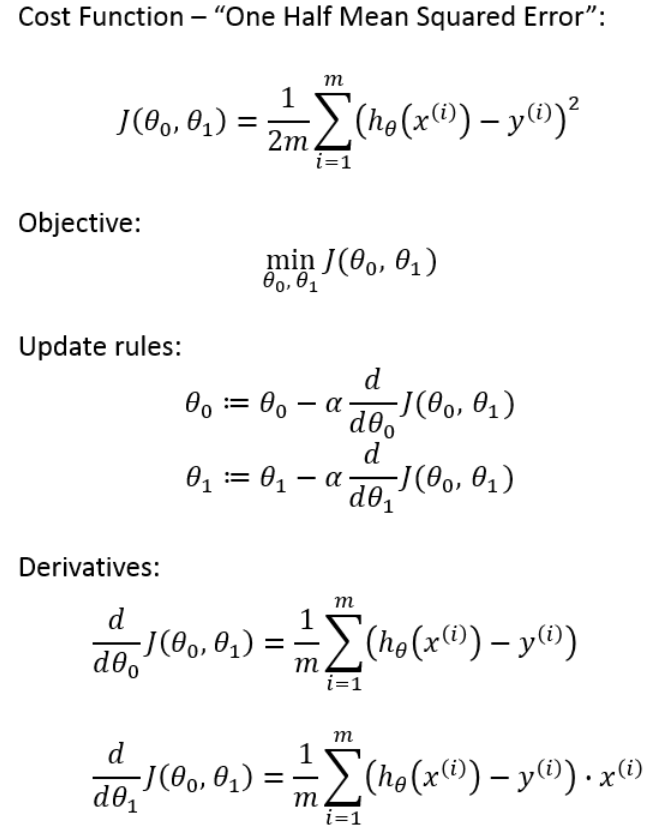

In [173]:
from IPython.display import Image
Image('C:\\Users\\Ashlesh B Shetty\\Desktop\\ZZ\\JobSearch\\GitHubRepos' +
      '\\DeepLearning-ArtificialIntelligence_ScikitLearn-TensorFlow\\images' + 
      '\\Image_GradientDescent_LinearRegression.png',
      width = 300)

### Using tf's autodiff which simplifies the gradient caluclation

In the above linear regression code we could replace the gradien= statement with just
> gradients = tf.gradients(mse, [theta])[0]

#### There are 4 main ways of computing gradients automatically and TF uses the reverse-mode autodiff, which is the best according to me  
(i)  Numerical Differentiation  
(ii) Symbolic Differentiation  
(iii)Forward-mode autodiff  
(iv) Reverse-mode autodiff   (TF uses this)

### Using tf's optimizer which further simplifies optimization

This will help us in replacing the original linear regression by gradient descent code's 2 lines (gradients and training_op) by below code lines. which automates both gradient calculation and gradient optimization calculations

> optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)  
> training_op = optimizer.minimize(mse)

If we wanted to use different optimizer in TF just change in th line

> optimizer = tf.train.MomentumOptimizer(learning_rate =learning_rate)

In [178]:
scaled_housing_data_plus_bias =sk.preprocessing.scale(housing_data_plus_bias)
n_epochs =1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype = tf.float32, name = "X")
Y = tf.constant(housing.target.reshape(-1,1), dtype = tf.float32, name = "Y")
theta = tf.Variable(tf.random_uniform([n+1,1],-1.0,1.0), name = "theta")
y_pred = tf.matmul(X, theta, name = "predictions")
error = y_pred -Y
mse = tf.reduce_mean(tf.square(error), name ="mse")

#gradients = 2/m * tf.matmul(tf.transpose(X),error)
#training_op = tf.assign(theta, theta - learning_rate * gradients )

optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)  
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 ==0:
            print("Epoch", epoch, "MSE=", mse.eval())
        sess.run(training_op)
    best_theta = theta.eval()

Epoch 0 MSE= 8.70353
Epoch 100 MSE= 5.089662
Epoch 200 MSE= 4.9755225
Epoch 300 MSE= 4.929323
Epoch 400 MSE= 4.8968115
Epoch 500 MSE= 4.8729854
Epoch 600 MSE= 4.8554225
Epoch 700 MSE= 4.8424473
Epoch 800 MSE= 4.8328323
Epoch 900 MSE= 4.8256645


### Feeding data to the algorithm

In [177]:
A = tf.placeholder(tf.float32, shape = (None,3))
B = A+5
with tf.Session() as sess:
    B_val_1 = B.eval(feed_dict = {A:[[1,2,3]]})
    B_val_2 = B.eval(feed_dict = {A:[[4,5,6],[7,8,9]]})
    
print(B_val_1)
print(B_val_2)      

[[6. 7. 8.]]
[[ 9. 10. 11.]
 [12. 13. 14.]]


If we wanted to implement feeding part into ourearlier gradient descent linear model we will have to do following minor changes

In [233]:
#import required libraries
import numpy as np
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing() 
m,n = housing.data.shape

#extract training and testing data
housing_data_plus_bias = np.c_[np.ones((m,1)), housing.data] # ads a column with ones to the  xvariables array 
scaled_housing_data_plus_bias =sk.preprocessing.scale(housing_data_plus_bias)
X_train = scaled_housing_data_plus_bias
Y_train = housing.target.reshape(-1,1)

#setup batchwise feeding data mechanism
batch_size = 100    
n_batches = int(np.ceil( m / batch_size))     
def fetch_batch(epoch, batch_index, batch_size):    
    np.random.seed(epoch * n_batches + batch_index)
    indices = np.random.randint(m, size=batch_size)
    X_batch = X_train[indices]
    Y_batch = Y_train[indices]
    return X_batch, Y_batch  

#set the number of iterations and learning rate
n_epochs =1000
learning_rate = 0.01

# use placeholder for feeding data while running
#X = tf.constant(scaled_housing_data_plus_bias, dtype = tf.float32, name = "X")
#Y = tf.constant(housing.target.reshape(-1,1), dtype = tf.float32, name = "Y")
X= tf.placeholder(tf.float32, shape = (None, n+1), name = "X")    
Y= tf.placeholder(tf.float32, shape = (None, 1), name = "Y")  

#setup theta, error calculation and evaluation metrics/ objective function
theta = tf.Variable(tf.random_uniform([n+1,1],-1.0,1.0), name = "theta")
y_pred = tf.matmul(X, theta, name = "predictions")
error = y_pred -Y
mse = tf.reduce_mean(tf.square(error), name ="mse")

#use tensorflows autodiff and auto optiimization fro simplifying training process
#gradients = 2/m * tf.matmul(tf.transpose(X),error)
#training_op = tf.assign(theta, theta - learning_rate * gradients )
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)  
training_op = optimizer.minimize(mse)

# Setup the tensor flow session

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):  
        if epoch % 100 ==0:
#             print("Epoch", epoch, "MSE=", mse.eval())
            print("MSE=%s" % sess.run(mse, feed_dict={X:X_train, Y:Y_train}))
        
        for batch_index in range(n_batches):  
            X_batch, Y_batch = fetch_batch(epoch, batch_index, batch_size)  
            sess.run(training_op, feed_dict = {X: X_batch, Y:Y_batch})  
        best_theta = theta.eval()

MSE=13.425032
MSE=4.8120155
MSE=4.8570895
MSE=4.832262
MSE=4.818971
MSE=4.812031
MSE=4.832228
MSE=4.8235593
MSE=4.8199735
MSE=5.0218945


### Saving and restoring the model

#### SAVING the model

In [25]:
#import required libraries
import numpy as np
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing() 
m,n = housing.data.shape

#extract training and testing data
housing_data_plus_bias = np.c_[np.ones((m,1)), housing.data] # ads a column with ones to the  xvariables array 
scaled_housing_data_plus_bias =sk.preprocessing.scale(housing_data_plus_bias)
X_train = scaled_housing_data_plus_bias
Y_train = housing.target.reshape(-1,1)

#setup batchwise feeding data mechanism
batch_size = 100    
n_batches = int(np.ceil( m / batch_size))     
def fetch_batch(epoch, batch_index, batch_size):    
    np.random.seed(epoch * n_batches + batch_index)
    indices = np.random.randint(m, size=batch_size)
    X_batch = X_train[indices]
    Y_batch = Y_train[indices]
    return X_batch, Y_batch  

#set the number of iterations and learning rate
n_epochs =1000
learning_rate = 0.01

# use placeholder for feeding data while running
X= tf.placeholder(tf.float32, shape = (None, n+1), name = "X")    
Y= tf.placeholder(tf.float32, shape = (None, 1), name = "Y")  

#setup theta, error calculation and evaluation metrics/ objective function
theta = tf.Variable(tf.random_uniform([n+1,1],-1.0,1.0), name = "theta")
y_pred = tf.matmul(X, theta, name = "predictions")
error = y_pred -Y
mse = tf.reduce_mean(tf.square(error), name ="mse")

#use tensorflows autodiff and auto optiimization fro simplifying training process
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)  
training_op = optimizer.minimize(mse)

# Setup the tensor flow session
init = tf.global_variables_initializer()
saver = tf.train.Saver() #saving the model for later

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):  
        if epoch % 100 ==0:
            print("MSE=%s" % sess.run(mse, feed_dict={X:X_train, Y:Y_train}))
        
        for batch_index in range(n_batches):  
            X_batch, Y_batch = fetch_batch(epoch, batch_index, batch_size)  
            sess.run(training_op, feed_dict = {X: X_batch, Y:Y_batch})  
        best_theta = theta.eval()
    save_path = saver.save(sess,'C:\\Users\\Ashlesh B Shetty\\Desktop\\ZZ\\JobSearch\\GitHubRepos' +
                           '\\DeepLearning-ArtificialIntelligence_ScikitLearn-TensorFlow\\images' + 
                           '\\my_model_final.ckpt ')

MSE=7.6220345
MSE=4.8120146
MSE=4.8570867
MSE=4.832263
MSE=4.81897
MSE=4.8120284
MSE=4.8322234
MSE=4.8235583
MSE=4.819976
MSE=5.021899


Above model was saved inside the location creating 4 of these files
* checkpoint
* my_model_final.ckpt .data-00000-of-00001
* my_model_final.ckpt .index
* my_model_final.ckpt .meta

#### Restoring the model
A saved model can be restored partially or completely. Below is the way to restore the saved model completely

In [175]:
with tf.Session() as sess:
    saver.restore(sess, 'C:\\Users\\Ashlesh B Shetty\\Desktop\\ZZ\\JobSearch\\GitHubRepos' +
      '\\DeepLearning-ArtificialIntelligence_ScikitLearn-TensorFlow\\images' + 
      '\\my_model_final.ckpt ')

INFO:tensorflow:Restoring parameters from C:\Users\Ashlesh B Shetty\Desktop\ZZ\JobSearch\GitHubRepos\DeepLearning-ArtificialIntelligence_ScikitLearn-TensorFlow\images\my_model_final.ckpt 


### Visualizing the graphs and training the curves using tensorflow

In [2]:
#initial part of the code for visualizing graph on tensor board
from datetime import datetime
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir,now)

#import required libraries
import numpy as np
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing() 
m,n = housing.data.shape

#extract training and testing data
housing_data_plus_bias = np.c_[np.ones((m,1)), housing.data] # ads a column with ones to the  xvariables array 
scaled_housing_data_plus_bias =sk.preprocessing.scale(housing_data_plus_bias)
X_train = scaled_housing_data_plus_bias
Y_train = housing.target.reshape(-1,1)

#setup batchwise feeding data mechanism
batch_size = 100    
n_batches = int(np.ceil( m / batch_size))     
def fetch_batch(epoch, batch_index, batch_size):    
    np.random.seed(epoch * n_batches + batch_index)
    indices = np.random.randint(m, size=batch_size)
    X_batch = X_train[indices]
    Y_batch = Y_train[indices]
    return X_batch, Y_batch  

#set the number of iterations and learning rate
n_epochs =1000
learning_rate = 0.01

# use placeholder for feeding data while running
X= tf.placeholder(tf.float32, shape = (None, n+1), name = "X")    
Y= tf.placeholder(tf.float32, shape = (None, 1), name = "Y")  

#setup theta, error calculation and evaluation metrics/ objective function
theta = tf.Variable(tf.random_uniform([n+1,1],-1.0,1.0), name = "theta")
y_pred = tf.matmul(X, theta, name = "predictions")
error = y_pred -Y
mse = tf.reduce_mean(tf.square(error), name ="mse")

#use tensorflows autodiff and auto optiimization fro simplifying training process
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)  
training_op = optimizer.minimize(mse)

# Setup the tensor flow session
init = tf.global_variables_initializer()
saver = tf.train.Saver() #saving the model for later

#End part of the code for visualizing graph on tensor board
mse_summary = tf.summary.scalar('MSE',mse)
file_writer = tf.summary.FileWriter(logdir,tf.get_default_graph())

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):  
        if epoch % 100 ==0:
            print("MSE=%s" % sess.run(mse, feed_dict={X:X_train, Y:Y_train}))
        
        for batch_index in range(n_batches):  
            X_batch, Y_batch = fetch_batch(epoch, batch_index, batch_size)  
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict = {X: X_batch, Y:Y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str,step)
                
            sess.run(training_op, feed_dict = {X: X_batch, Y:Y_batch})  
        best_theta = theta.eval()
    save_path = saver.save(sess,'C:\\Users\\Ashlesh B Shetty\\Desktop\\ZZ\\JobSearch\\GitHubRepos' +
                           '\\DeepLearning-ArtificialIntelligence_ScikitLearn-TensorFlow\\images' + 
                           '\\my_model_final.ckpt ')

file_writer.close()

MSE=6.379227
MSE=4.8120146
MSE=4.8570867
MSE=4.832263
MSE=4.81897
MSE=4.8120284
MSE=4.8322234
MSE=4.8235583
MSE=4.819976
MSE=5.021899


In [3]:
# going to working directory the following are the logfiles that got created when I ran the above code
!ls -l tf_logs/

total 0
drwxr-xr-x 1 Ashlesh B Shetty 197121 0 Mar 11 18:12 run-20180311231251


Type the below code inside startebot to get a link with port to open tensorboard
>python -m tensorboard.main --logdir=tf_logs/

Sample output
TensorBoard 1.6.0 at http://LAPTOP-233T38K5:6006 (Press CTRL+C to quit)

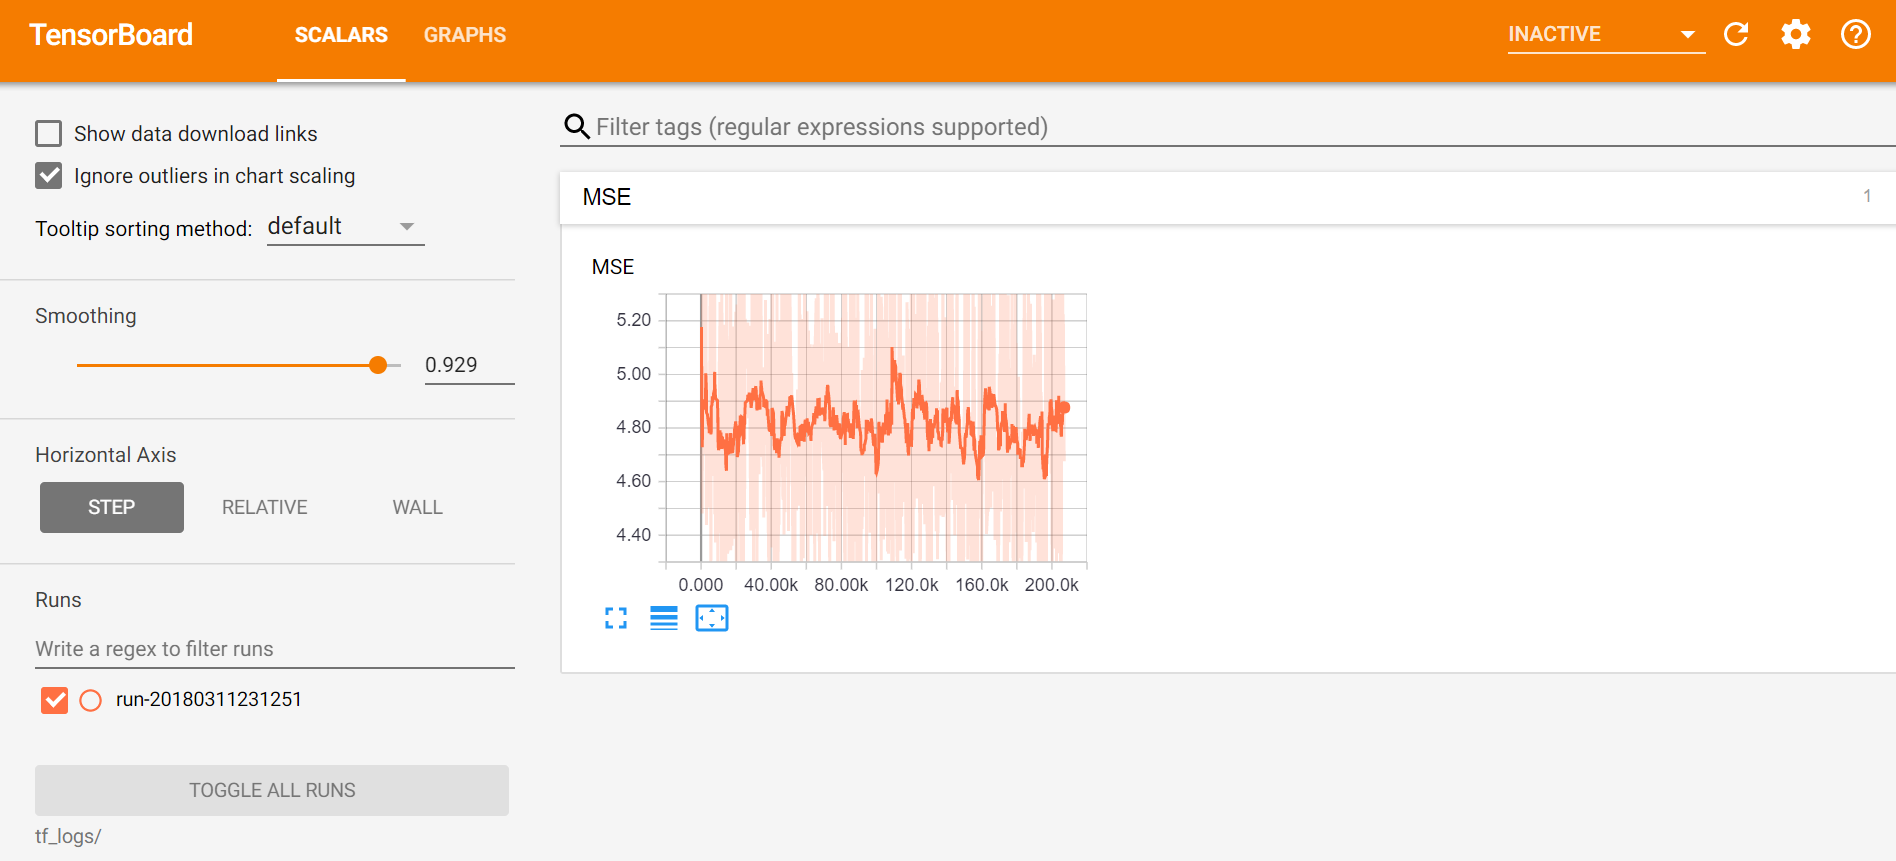

In [10]:
from IPython.display import Image
Image('C:\\Users\\Ashlesh B Shetty\\Desktop\\ZZ\\JobSearch\\GitHubRepos' +
      '\\DeepLearning-ArtificialIntelligence_ScikitLearn-TensorFlow\\images' + 
      '\\TF_Scalar_OP.png',
      width = 700)

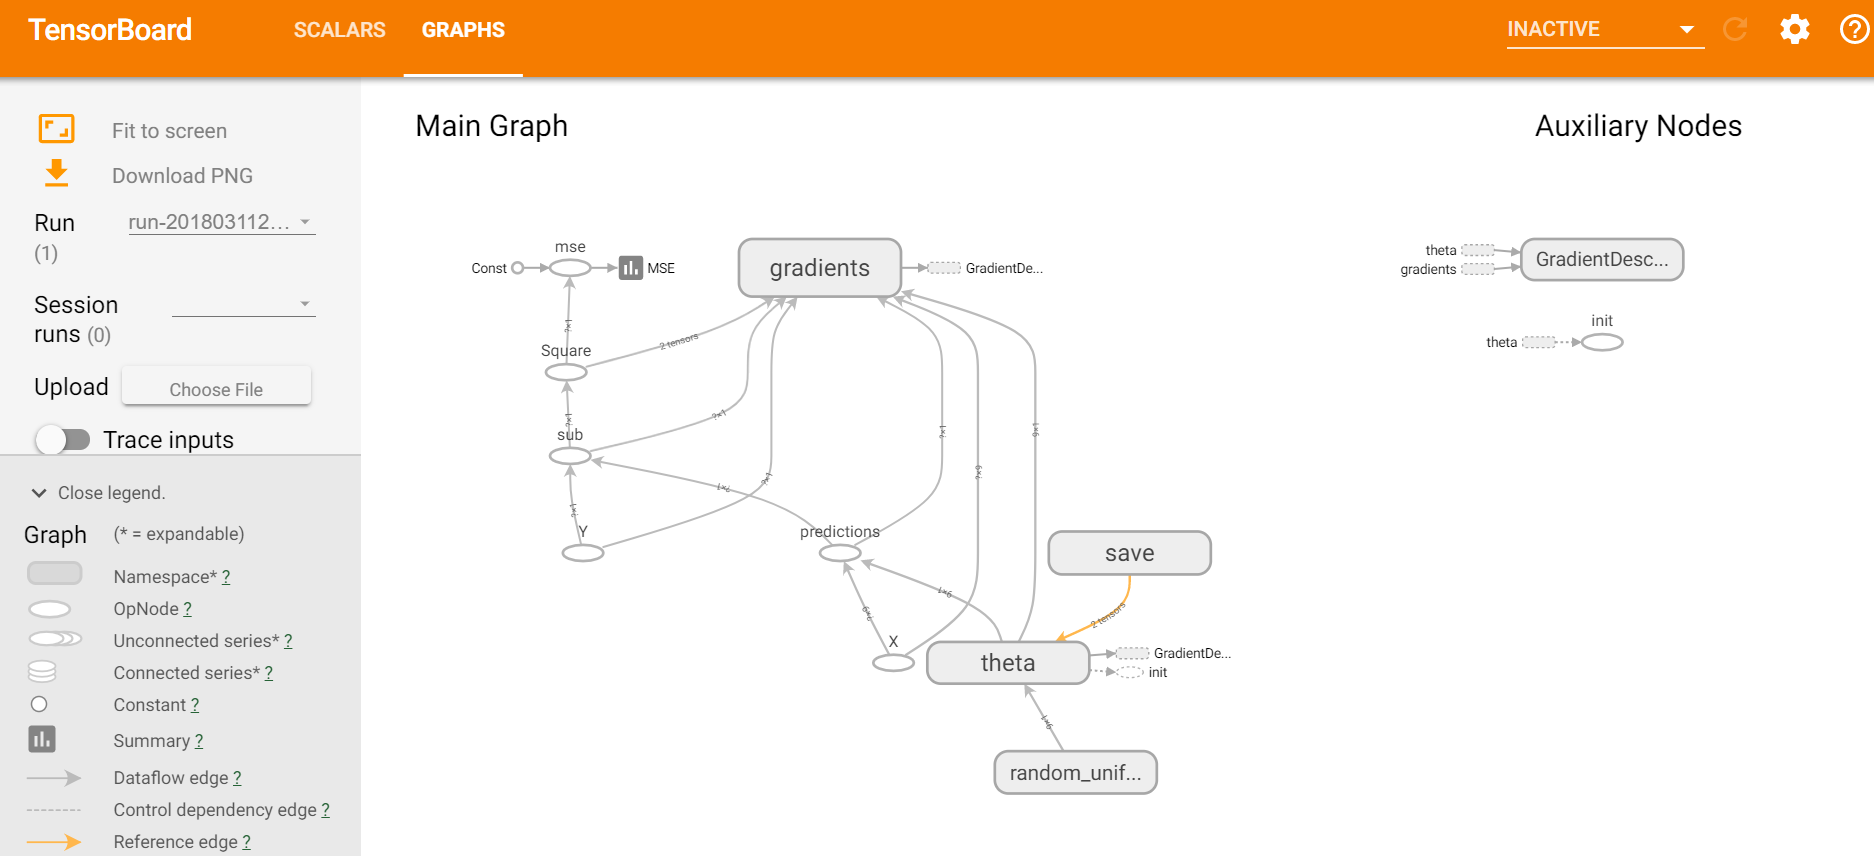

In [9]:
Image('C:\\Users\\Ashlesh B Shetty\\Desktop\\ZZ\\JobSearch\\GitHubRepos' +
      '\\DeepLearning-ArtificialIntelligence_ScikitLearn-TensorFlow\\images' + 
      '\\TF_Graphs_OP.png',
      width = 700)

### Name Scopes

To simplify graphs, especially when doing deep neural networks we use Name scoopes to group things and simplify graphs

In [17]:
tf.reset_default_graph()
#initial part of the code for visualizing graph on tensor board
from datetime import datetime
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir,now)

#import required libraries
import numpy as np
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing() 
m,n = housing.data.shape

#extract training and testing data
housing_data_plus_bias = np.c_[np.ones((m,1)), housing.data] # ads a column with ones to the  xvariables array 
scaled_housing_data_plus_bias =sk.preprocessing.scale(housing_data_plus_bias)
X_train = scaled_housing_data_plus_bias
Y_train = housing.target.reshape(-1,1)

#setup batchwise feeding data mechanism
batch_size = 100    
n_batches = int(np.ceil( m / batch_size))     
def fetch_batch(epoch, batch_index, batch_size):    
    np.random.seed(epoch * n_batches + batch_index)
    indices = np.random.randint(m, size=batch_size)
    X_batch = X_train[indices]
    Y_batch = Y_train[indices]
    return X_batch, Y_batch  

#set the number of iterations and learning rate
n_epochs =1000
learning_rate = 0.01

# use placeholder for feeding data while running
X= tf.placeholder(tf.float32, shape = (None, n+1), name = "X")    
Y= tf.placeholder(tf.float32, shape = (None, 1), name = "Y")  


#setup theta, error calculation and evaluation metrics/ objective function
theta = tf.Variable(tf.random_uniform([n+1,1],-1.0,1.0), name = "theta")
y_pred = tf.matmul(X, theta, name = "predictions")
# error = y_pred -Y
# mse = tf.reduce_mean(tf.square(error), name ="mse")

#this chunk of the code helps in Name scoping for simplification of Tensorboard graphs
with tf.name_scope("loss") as scope:
    error = y_pred - Y
    mse = tf.reduce_mean(tf.square(error),name = "mse")



#use tensorflows autodiff and auto optiimization fro simplifying training process
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)  
training_op = optimizer.minimize(mse)

# Setup the tensor flow session
init = tf.global_variables_initializer()
saver = tf.train.Saver() #saving the model for later

#End part of the code for visualizing graph on tensor board
mse_summary = tf.summary.scalar('MSE',mse)
file_writer = tf.summary.FileWriter(logdir,tf.get_default_graph())

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):  
        if epoch % 100 ==0:
            print("MSE=%s" % sess.run(mse, feed_dict={X:X_train, Y:Y_train}))
        
        for batch_index in range(n_batches):  
            X_batch, Y_batch = fetch_batch(epoch, batch_index, batch_size)  
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict = {X: X_batch, Y:Y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str,step)
                
            sess.run(training_op, feed_dict = {X: X_batch, Y:Y_batch})  
        best_theta = theta.eval()
    save_path = saver.save(sess,'C:\\Users\\Ashlesh B Shetty\\Desktop\\ZZ\\JobSearch\\GitHubRepos' +
                           '\\DeepLearning-ArtificialIntelligence_ScikitLearn-TensorFlow\\images' + 
                           '\\my_model_final.ckpt ')

file_writer.close()

MSE=6.6376786
MSE=4.8120146
MSE=4.8570867
MSE=4.832263
MSE=4.81897
MSE=4.8120284
MSE=4.8322234
MSE=4.8235583
MSE=4.819976
MSE=5.021899


The tensorboard graph that was plotted earlier gets simplified to following below graph due to the Name scoping implemented into the code

In [18]:
!ls -l tf_logs/

total 0
drwxr-xr-x 1 Ashlesh B Shetty 197121 0 Mar 11 18:12 run-20180311231251
drwxr-xr-x 1 Ashlesh B Shetty 197121 0 Mar 11 18:34 run-20180311233432
drwxr-xr-x 1 Ashlesh B Shetty 197121 0 Mar 11 18:45 run-20180311234508


Since now I have ran the code thrice we have 3 log files.
Now lets see the tensorboard

In [20]:
print(mse.op.name)
print(error.op.name)

loss/mse
loss/sub


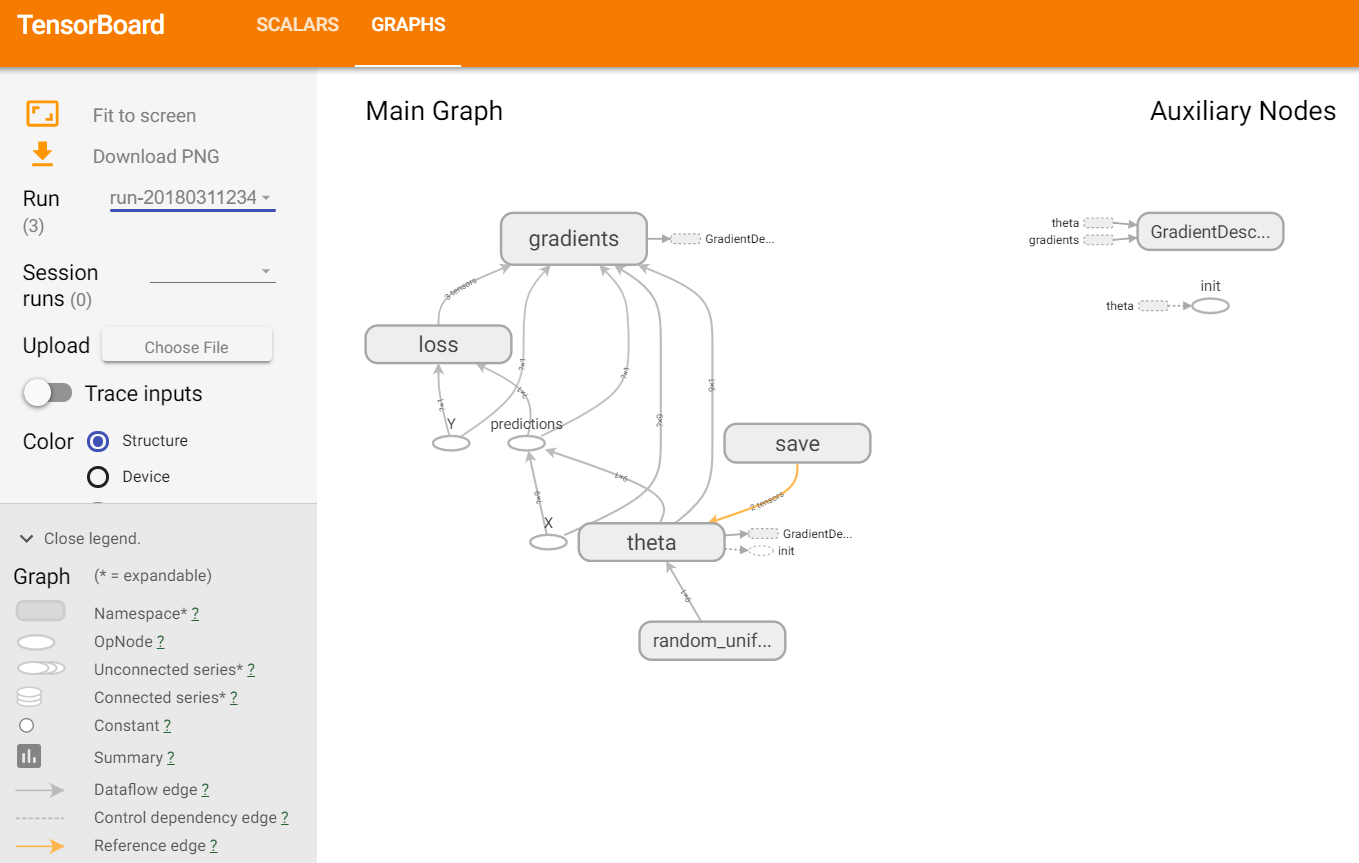

In [22]:
Image('C:\\Users\\Ashlesh B Shetty\\Desktop\\ZZ\\JobSearch\\GitHubRepos' +
      '\\DeepLearning-ArtificialIntelligence_ScikitLearn-TensorFlow\\images' + 
      '\\TF_Graphs_OP_simplified.png',
      width = 700)

### Modularity

If there are multiple functions. For example you have 5 relu function to run then you need not worry or repeat 5 times . Just define the function and call the function 5 times. When Tensorflow detects same variable created again and again it incrementally ads subxcrip numbers and combines it together as a module to keep the end graph simple and compact.

In [31]:
n_features =3
X= tf.placeholder(tf.float32, shape = (None, n_features), name = "X")

w1 = tf.Variable(tf.random_normal((n_features,1)), name = "weights1")
w2 = tf.Variable(tf.random_normal((n_features,1)), name = "weights2")
b1 = tf.Variable(0.0, name = 'bias1')
b2 = tf.Variable(0.0, name = 'bias2')

z1 = tf.add(tf.matmul(X,w1),b1,name = "z1")
z2 = tf.add(tf.matmul(X,w1),b1,name = "z2")

relu1 = tf.maximum(z1,0., name ="relu1")
relu2 = tf.maximum(z2,0., name ="relu2")

output = tf.add(relu1,relu2, name  = "output")

The above code keeps getting complicated as we add more relu so we can rather do the below code and tensor flow willhandle the repetition

In [50]:
def relu(X):
    w_shape = (int(X.get_shape()[1]),1)
    w = tf.Variable(tf.random_normal(w_shape), name = 'weights')
    b = tf.Variable(0.0, name = 'bias')
    z = tf.add(tf.matmul(X,w),b,name = 'z')
    return tf.maximum(z,0, name = "relu")

n_features = 3
X= tf.placeholder(tf.float32, shape = (None, n_features), name = "X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name = "output")

### Sharing Variables

There are multiways to reduce redundancy of shared variables across various components.   
Some of the options available are listed below. Tensor Flow also comes up with a way to share variables, which is also mentioned below  
1. Create a variable first and pass it onto the function
2. Create a python dictionry containing all the variables in the model
3. Create a class using each module
4. Set the shared variable as an attribute of the function
5. TensorFlows option: get_variable

without reuse we will have to set shape and initialize the value for the shared variable
if explicitly mentioned to reuse then we neednot mention shape and initialize as given below
```python
with tf.variable_scope("relu", reuse = True):
    threshold  = tf.get_variable("threshold")
```

By implementing Tensor flows get_variable and variable_scope our program and also graph on tensorboard gets simpler

```python
def relu(X):
    with tf.variable_scope("relu", reuse = True):
        threshold = tf.get_variable("threshold")
        [.....]
        return tf.maximum(z, treshold, name = "max")
        
X= tf.placeholder(tf.float32, shape = (None, n_features), name = "X")
with tf.variable_scope("relu"):
    threshold = tf.get_variable("threshold", shape = (),
                                initializer = tf.constant_initializer(0.0))
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name = "output")

```




 